In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%matplotlib inline

# install pillow
# !pip uninstall -y Pillow
# !pip install Pillow==4.1.1

# download and unzip dataset o train
# !wget http://images.cocodataset.org/zips/train2014.zip
# !mkdir train
# %cd /content/train
# !unzip -qq /content/train2014.zip
# %cd ..

#download model
!wget https://web.eecs.umich.edu/~justincj/models/vgg16-00b39a1b.pth

# download helper code
!wget https://raw.githubusercontent.com/iamRusty/fast-neural-style-pytorch/master/transformer.py
!wget https://raw.githubusercontent.com/iamRusty/fast-neural-style-pytorch/master/experimental.py
!wget https://raw.githubusercontent.com/iamRusty/fast-neural-style-pytorch/master/utils.py
!wget https://raw.githubusercontent.com/iamRusty/fast-neural-style-pytorch/master/vgg.py

# download style image
!wget https://raw.githubusercontent.com/iamRusty/fast-neural-style-pytorch/master/images/mosaic.jpg

--2024-03-16 21:48:40--  https://web.eecs.umich.edu/~justincj/models/vgg16-00b39a1b.pth
Resolving web.eecs.umich.edu (web.eecs.umich.edu)... 141.212.113.214
Connecting to web.eecs.umich.edu (web.eecs.umich.edu)|141.212.113.214|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 553451520 (528M) [application/x-tar]
Saving to: ‘vgg16-00b39a1b.pth’

vgg16-00b39a1b.pth  100%[===================>] 527.81M   111MB/s    in 4.9s    

2024-03-16 21:48:45 (107 MB/s) - ‘vgg16-00b39a1b.pth’ saved [553451520/553451520]

--2024-03-16 21:48:46--  https://raw.githubusercontent.com/iamRusty/fast-neural-style-pytorch/master/transformer.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4660 (4.6K) [text/plain]
Saving to: ‘transformer.py’

transformer.py 

In [ ]:
def get_file_with_largest_number(folder_path):
    # Get list of files in folder
    files = os.listdir(folder_path)

    # If the folder is empty, return None
    if not files:
        return None

    # Sort files based on numbers in filenames
    sorted_files = sorted(files, key=lambda x: int(re.search(r'\d+', x).group()), reverse=True)

    # Return the file with the largest number
    return sorted_files[0]

In [ ]:
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import random
import numpy as np
import time
import vgg
import transformer
import experimental
import utils
from google.colab.patches import cv2_imshow
import re


In [ ]:
# GLOBAL SETTINGS
TRAIN_IMAGE_SIZE = 256
DATASET_PATH = "/content/drive/MyDrive/ISIMA/Machine Learning & Data Mining /GAN Project/Dataset/dataset/Neural Style Transfer/"
NUM_EPOCHS = 1
STYLE_IMAGE_PATH = "/content/drive/MyDrive/ISIMA/Machine Learning & Data Mining /GAN Project/Dataset/dataset/r256x256/25600118.jpg"
BATCH_SIZE = 4
CONTENT_WEIGHT = 17
STYLE_WEIGHT = 50
TV_WEIGHT = 1e-6
ADAM_LR = 0.001
SAVE_MODEL_PATH = "/content/drive/MyDrive/ISIMA/Machine Learning & Data Mining /GAN Project/Code/Neural Style Transfer/outputs/6. mosaic_TransformerNetworkUNetDenseNetResNet/checkpoints/"
SAVE_IMAGE_PATH = "/content/drive/MyDrive/ISIMA/Machine Learning & Data Mining /GAN Project/Code/Neural Style Transfer/outputs/6. mosaic_TransformerNetworkUNetDenseNetResNet/images/"
SAVE_MODEL_EVERY = 500 # 2,000 Images with batch size 4
SEED = 35
CHECKPOINT_PATH = get_file_with_largest_number(SAVE_MODEL_PATH)


In [ ]:
def extract_number_from_filename(filename):
    # Extract numbers using regular expression
    match = re.search(r'\d+', filename)
    if match:
        number = int(match.group())
        return number
    else:
        return None  # Return None if no number is found

# Example usage:
filename = CHECKPOINT_PATH
number = extract_number_from_filename(filename)
number = number + 500
print(number)  # Output: 2500
# print(type(number))  # Output: <class 'int'>

500


In [ ]:
CHECKPOINT_PATH = os.path.join(SAVE_MODEL_PATH, CHECKPOINT_PATH)
CHECKPOINT_PATH

'/content/drive/MyDrive/ISIMA/Machine Learning & Data Mining /GAN Project/Code/Neural Style Transfer/outputs/6. mosaic_TransformerNetworkUNetDenseNetResNet/checkpoints/checkpoint_0.pth'

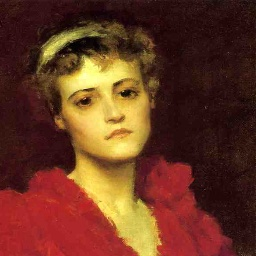

In [ ]:

# Assuming you have a BGR image named "bgr_image.png"
bgr_image = cv2.imread("/content/25600118.jpg")
image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)

# Now you have an RGB image
# You can display or save it using OpenCV or any other library
cv2_imshow(image)

cv2.imwrite("/content/style_image.png", image)

STYLE_IMAGE_PATH = "/content/style_image.png"

In [ ]:
def delete_files_with_unwanted_extensions(folder_path):
    # Define allowed extensions
    allowed_extensions = ['.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp']

    # Get list of files in folder
    files = os.listdir(folder_path)

    # Iterate through each file
    for file_name in files:
        file_path = os.path.join(folder_path, file_name)
        # Check if the file is not a directory and has an extension
        if os.path.isfile(file_path) and os.path.splitext(file_name)[1].lower() not in allowed_extensions:
            # Delete the file
            os.remove(file_path)

In [ ]:
delete_files_with_unwanted_extensions("/content/drive/MyDrive/ISIMA/Machine Learning & Data Mining /GAN Project/Dataset/dataset/Neural Style Transfer/img_align_celeba")

In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.5/263.5 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.4 MB/s eta 0:00:00


In [ ]:
import wandb
wandb_key="584a425bc6cdb37694ed273266afc3d05ffce9c1"
wandb.login(key=wandb_key)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# import wandb
# import random

# # start a new wandb run to track this script
# wandb.init(
#     # set the wandb project where this run will be logged
#     project="Neural Style Transfer",
#     name= "TransformerNetworkUNetDenseNetResNet"

# )


In [ ]:
wandb.run.id

In [ ]:
run_id="7thmpwmg"

In [ ]:
wandb.init(
    # set the wandb project where this run will be logged
    project="Neural Style Transfer",
    id= run_id,
    resume= "must"
)


wandb: Currently logged in as: jl_mahdid (billal-mokhtari). Use `wandb login --relogin` to force relogin


========Epoch 1/2========
========Iteration 1/9306========
	Content Loss:	8450.87
	Style Loss:	25984266.00
	Total Loss:	25992716.00
Time elapsed:	22.296544551849365 seconds
Saved TransformerNetwork checkpoint file at /content/drive/MyDrive/ISIMA/Machine Learning & Data Mining /GAN Project/Code/Neural Style Transfer/outputs/6. mosaic_TransformerNetworkUNetDenseNetResNet/checkpoints/checkpoint_500.pth


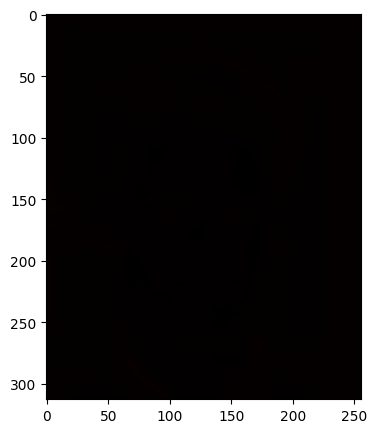

Saved sample tranformed image at /content/drive/MyDrive/ISIMA/Machine Learning & Data Mining /GAN Project/Code/Neural Style Transfer/outputs/6. mosaic_TransformerNetworkUNetDenseNetResNet/images/sample0_500.png


In [ ]:
from pickle import NONE
def train():
    # Seeds
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

    # Device
    device = ("cuda" if torch.cuda.is_available() else "cpu")

    # Dataset and Dataloader
    transform = transforms.Compose([
        transforms.Resize(TRAIN_IMAGE_SIZE),
        # transforms.CenterCrop(TRAIN_IMAGE_SIZE),
        transforms.ToTensor(),
        # transforms.Lambda(lambda x: x.mul(255))
    ])
    train_dataset = datasets.ImageFolder(DATASET_PATH, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    # Load networks
    #TransformerNetwork = transformer.TransformerNetwork().to(device)
    TransformerNetwork = experimental.TransformerNetworkUNetDenseNetResNet().to(device)

    VGG = vgg.VGG16('/content/vgg16-00b39a1b.pth').to(device)

    # Get Style Features
    imagenet_neg_mean = torch.tensor([-103.939, -116.779, -123.68], dtype=torch.float32).reshape(1,3,1,1).to(device)
    imagenet_mean = torch.tensor([103.939, 116.779, 123.68], dtype=torch.float32).reshape(1,3,1,1).to(device)
    style_image = utils.load_image(STYLE_IMAGE_PATH)
    style_tensor = utils.itot(style_image).to(device)
    style_tensor = style_tensor.add(imagenet_neg_mean)
    B, C, H, W = style_tensor.shape
    style_features = VGG(style_tensor.expand([BATCH_SIZE, C, H, W]))
    style_gram = {}
    for key, value in style_features.items():
        style_gram[key] = utils.gram(value)

    if CHECKPOINT_PATH is not None:
      TransformerNetwork.load_state_dict(torch.load(CHECKPOINT_PATH))


    # Optimizer settings
    optimizer = optim.Adam(TransformerNetwork.parameters(), lr=ADAM_LR)

    # Loss trackers
    content_loss_history = []
    style_loss_history = []
    total_loss_history = []
    batch_content_loss_sum = 0
    batch_style_loss_sum = 0
    batch_total_loss_sum = 0

    # Optimization/Training Loop
    batch_count = 1
    start_time = time.time()
    for epoch in range (1, NUM_EPOCHS+1):
        print("========Epoch {}/{}========".format(epoch, NUM_EPOCHS+1))
        for batch_id, (content_batch, _) in enumerate(train_loader):
            # Current Batch size in case of odd batches
            curr_batch_size = content_batch.shape[0]

            # Zero-out Gradients
            optimizer.zero_grad()

            # Generate images and get features
            content_batch = content_batch[:,[2,1,0]].to(device)
            generated_batch = TransformerNetwork(content_batch)
            content_features = VGG(content_batch.add(imagenet_neg_mean))
            generated_features = VGG(generated_batch.add(imagenet_neg_mean))

            # Content Loss
            MSELoss = nn.MSELoss().to(device)
            content_loss = CONTENT_WEIGHT * MSELoss(content_features['relu2_2'], generated_features['relu2_2'])
            batch_content_loss_sum += content_loss

            # Style Loss
            style_loss = 0
            for key, value in generated_features.items():
                s_loss = MSELoss(utils.gram(value), style_gram[key][:curr_batch_size])
                style_loss += s_loss
            style_loss *= STYLE_WEIGHT
            batch_style_loss_sum += style_loss

            # Total Loss
            total_loss = content_loss + style_loss
            batch_total_loss_sum += total_loss.item()

            # Backprop and Weight Update
            total_loss.backward()
            optimizer.step()

            # Save Model and Print Losses
            if (((batch_count-1)%SAVE_MODEL_EVERY == 0) or (batch_count==NUM_EPOCHS*len(train_loader))):
                # Print Losses
                print("========Iteration {}/{}========".format(batch_count, NUM_EPOCHS*len(train_loader)))
                print("\tContent Loss:\t{:.2f}".format(batch_content_loss_sum/batch_count))
                print("\tStyle Loss:\t{:.2f}".format(batch_style_loss_sum/batch_count))
                print("\tTotal Loss:\t{:.2f}".format(batch_total_loss_sum/batch_count))
                print("Time elapsed:\t{} seconds".format(time.time()-start_time))

                # Save Model
                checkpoint_path = SAVE_MODEL_PATH + "checkpoint_" + str(batch_count-1+number) + ".pth"
                torch.save(TransformerNetwork.state_dict(), checkpoint_path)
                print("Saved TransformerNetwork checkpoint file at {}".format(checkpoint_path))

                # Save sample generated image
                sample_tensor = generated_batch[0].clone().detach().unsqueeze(dim=0)
                sample_image = utils.ttoi(sample_tensor.clone().detach())
                sample_image_path = SAVE_IMAGE_PATH + "sample0_" + str(batch_count-1+number) + ".png"
                utils.saveimg(sample_image, sample_image_path)
                utils.show(sample_image)
                print("Saved sample tranformed image at {}".format(sample_image_path))

                # Save loss histories
                content_loss_history.append(batch_content_loss_sum/batch_count)
                style_loss_history.append(batch_style_loss_sum/batch_count)
                total_loss_history.append(batch_total_loss_sum/batch_count)

                wandb.log({"batch content loss": batch_content_loss_sum/batch_count})
                wandb.log({"batch style loss": batch_style_loss_sum/batch_count})
                wandb.log({"batch total loss": batch_total_loss_sum/batch_count})

            # Iterate Batch Counter
            batch_count+=1

    stop_time = time.time()
    # Print loss histories
    print("Done Training the Transformer Network!")
    print("Training Time: {} seconds".format(stop_time-start_time))
    print("========Content Loss========")
    print(content_loss_history)
    print("========Style Loss========")
    print(style_loss_history)
    print("========Total Loss========")
    print(total_loss_history)

    # Save TransformerNetwork weights
    TransformerNetwork.eval()
    TransformerNetwork.cpu()
    final_path = SAVE_MODEL_PATH + "transformer_weight.pth"
    print("Saving TransformerNetwork weights at {}".format(final_path))
    torch.save(TransformerNetwork.state_dict(), final_path)
    print("Done saving final model")

train()